In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score as CVS
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse as RMSE
import scipy.stats as stats
import numbers
import pickle
import folium

## Modelling
Modelling requires several different operations. For ease of repetition, I decided to make functions for these operations, with different options for each which could even be used together.    
The different operations and their functions are:     
 - Transform the Data
  - polynom
  - log
  - minmax_plus
  - norm
  - ohe
 - Feature Selection
  - simple_selector
  - stepwise_selector
  - rfe_selector
 - Handling Multicollinearity
  - multicoll_remove
 - Create the Model
  - model
 - Measuring Results
  - metrics

### polynom
This function creates polynomial columns for the features passed in as to_poly. If poly is 'all' it also creates columns for multiplications between the columns passed in. Lastly, though it gets column names from poly.get_feature_names, these have to be altered to make it readable by statsmodels' ols function.

In [4]:
def polynom(data_t, to_poly, poly='all'):
    poly_order = 2
    if poly == 'all':
        poly=PF(poly_order)
        data_poly = poly.fit_transform(data_t[to_poly])
        data_poly = pd.DataFrame(data_poly)
        data_poly.columns = poly.get_feature_names(data_t[to_poly].columns)
        data_t = pd.concat([data_t.drop(to_poly, axis=1),
                            data_poly.drop('1',axis=1)], axis=1)
        data_t.rename(lambda col: col.replace('.0', '').replace(' ','__')
                  .replace('^','_pow_'), axis=1, inplace=True)
    elif poly == 'singles':
        for feat in to_poly:
            df = pd.DataFrame(data_t[feat])
            print(feat)
            poly=PF(poly_order)
            data_poly = poly.fit_transform(df)
            data_poly = pd.DataFrame(data_poly)
            data_poly.columns = ['drop', feat, feat + '_squared']
            data_t = pd.concat([data_t.drop(feat, axis=1), 
                                data_poly.drop('drop',axis=1)], axis=1)
    return data_t 

### log
log simply replaces the data with the log of the data for the columns passed in as to_log

In [5]:
def log(data_t, to_log):
    for feat in to_log:
        data_t[feat] = data_t[feat].map(lambda x: np.log(x) if x!=0 else 0)
        #Note 'if' included so that 0 values wouldn't error, will still error
        #...between 0 and 1. Also, implies that the original 0 value was a 1
        #...but as these are around values of 100s, 1000s, the effect is minimal
    return data_t 


### norm
For each column in to_norm, if this isn't the test data, norm calculates its mean and stdev, using them to normalise the column's values. It then records the statistics used for each column so they can be used later for the test data.   
If this is test data (test=True) it reads the stats from the record made previously

In [6]:
def norm(data_t, to_norm, test=False):
    stats = {}
    if test:
        with open('norm_stats.pickle', 'rb') as f:
            stats = pickle.load(f)
    for feat in to_norm:
        ft = data_t[feat]
        if test:
            mean = stats[feat][0]
            stdev = stats[feat][1]
        else:
            mean = np.mean(ft)
            stdev = np.sqrt(np.var(ft))
        data_t[feat] = (ft-mean) / stdev
        stats[feat] = [mean, stdev]
    with open('norm_stats.pickle', 'wb') as f:
        pickle.dump(stats, f)
    return data_t 


### minmax_plus
This function performs min-max scaling on the columns in to_minmax, and also  multiplies by 100, and adds 1 to,each value to make them log-able. It records the stats used for the train-data and reads it for test-data, in the same way as norm.

In [7]:
def minmax_plus(data_t, to_minmax, test=False):
    stats = {}
    if test:
        with open('minmax_stats.pickle', 'rb') as f:
            stats = pickle.load(f)
    for feat in to_minmax:
        ft = data_t[feat]
        if test:
            min_ = stats[feat][0]
            max_ = stats[feat][1]
        else:
            min_ = ft.min()
            max_ = ft.max()
        data_t[feat] = 1 + 100*(ft-min_)/(max_-min_)
        stats[feat] = [min_, max_]
    with open('minmax_stats.pickle', 'wb') as f:
        pickle.dump(stats, f)
    return data_t 


### ohe
ohe gets dummies for the columns in to_ohe, drops the original, and adds these columns to the dataframe. Lastly, the column names have to be altered to make it readable by statsmodels' ols function.

In [8]:
def ohe(data_t, to_ohe):
    for feat in to_ohe:
        dummies = pd.get_dummies(data=data_t[feat], prefix=feat, prefix_sep='_',
                                drop_first=True)
        data_t.drop(feat, axis=1, inplace=True)
        data_t = pd.concat([data_t, dummies], axis=1)
    data_t.rename(lambda col: col.replace('.0', '').replace(' ','__')
                  .replace('^','_pow_'),
                  axis=1, inplace=True)
    return data_t 


### bin_latlong
Calculates (or looks up if it's test data) 5 equal divisions in each of lat and long. Then, for each row, it uses floor division by the bin size to calculate which bin the lat-long belongs in. The bin number increases by latitude first and then by longitude.

In [9]:
def bin_latlong(data_t, test=False):
    
    if not test:
        max_lat = data_t['lat'].max()
        min_lat = data_t['lat'].min()
        x=(max_lat - min_lat)/5

        max_long = data_t['long'].max()
        min_long = data_t['long'].min()
        y=(max_long - min_long)/5
        latlong_vals = [x, min_lat, y, min_long]
        
        with open('latlong_vals.pickle', 'wb') as f:
            pickle.dump(latlong_vals, f)
    else:
        with open('latlong_vals.pickle', 'rb') as f:
            latlong_vals = pickle.load(f)
        x = latlong_vals[0]
        min_lat = latlong_vals[1]
        y = latlong_vals[2]
        min_long = latlong_vals[3]
    
    data_t.loc[:,'lat_long'] = data_t.apply(lambda row: (row.lat-min_lat)//x
                                      + 5*(row.long-min_long)//y, axis=1)
    
    
    
    return data_t

In [10]:
def bin_basement(data_t):
    data_t.sqft_basement = data_t.sqft_basement.apply(lambda x: 
                                                      1 if not x else 0)
    return data_t

### simple_selector
simple_selector starts by calling the model function, returning a model using all the features in x_cols. Only the features in x_cols with a pvalue lower than or equal to alpha are kept and returned.

In [11]:
def simple_selector(data_s, x_cols, alpha=0.1):
    
    results = model(data_s, x_cols)
    pv = pd.DataFrame(results.pvalues).drop('Intercept')
    pv.rename(columns={0:'p_value'}, inplace=True)
    x_cols = list(pv[pv.p_value <= alpha].index)
    
    return x_cols

### stepwise_selector
In this function loops adding or removing features depending on their pvalue each iteration; breaking out of the loop when stable.

In [12]:
def stepwise_selector(data_s, 
                       x_cols=[], 
                       alpha=0.05, 
                       verbose=False):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        x_cols - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    
    X = data_s[x_cols]
    y = data_s['price']
    threshold_in = alpha - 0.02
    threshold_out = alpha + 0.02
    included = list(x_cols)
    while True:
        print(len(included))
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            results = sm.OLS(y, sm.add_constant
                             (pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = results.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        results = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = results.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, 
                                                             worst_pval))
        if not changed:
            break
            
    return included

### rfe_selector
Here features are selected using sklearn's recursive-feature-elimination function for a range of numbers-of-features. Models are created for each set of features and the adjusted r-squared is plotted against the number of features. Using this graph, and the list of results, you can choose how many features you want to select. Enter this number when asked and it will call this function again. But this time specifying the number of features to select and returning with the selected features.     
Note: tried using mpld3 to show y-values when hovering over markers but couldn't get the graph to appear before asking for input.

In [132]:
def rfe_selector(data_s, x_cols, nfts=None):
    X = data_s[x_cols]
    y = data_s[outcome]
    linreg = LR()
    r2_adj = []
    
    n = nfts or 1
    n_max = min(len(x_cols), 80)
    r = range(n, n_max+1)
    while n <= n_max:
   
        selector = RFE(linreg, n_features_to_select=n)
        results = selector.fit(X, y)

        new_cols = []
        for i in range(len(x_cols)):
            if results.support_[i]:
                new_cols.append(x_cols[i])
        
        results = model(data_s, new_cols)
        r2_adj.append(results.rsquared_adj)
        if nfts:
            return new_cols
        n+=1
    print(list(zip(r, r2_adj)))
    fig, ax = plt.subplots()
    lines = ax.plot(r, r2_adj, marker='o')
    ax.set(xlabel='Number of Features', ylabel='Adj. R^2', 
           title = 'Select Number of Features');
    
    plt.show(block=False)
    
    
    
    print('Select number of features')
    choice = int(input())
    new_cols = rfe_selector(data_s, x_cols, nfts=choice)
    
    return new_cols

### Multicoll_remove    
This function removes a feature from each pair with high multicollinearity    
This function takes in the data, x_cols and the threshold for removing a feature

- create a dataframe of the correlation of the features in x_cols   
- transform this to get a list of pairs of features with high multicollinearity
- for each pair: check whether they are the same feature or if one of the features has already been listed to be removed; if so, continue to next pair 
- otherwise add the feature with the higher p-value to a list    
- remove the features in this list from x_cols    


return x_cols     




In [14]:
def multicoll_remove(data_mr, x_cols, multicollinearity_threshold):
    
    pvalues = model(data_mr, x_cols).pvalues
    corr = data_mr[x_cols].corr().abs().stack().reset_index().sort_values(0,
                                                            ascending = False)
    corr['pairs'] = list(zip(corr.level_0, corr.level_1))
    corr = corr.set_index('pairs').drop(['level_0', 'level_1'], axis=1)
    corr.columns = ['cc']
    corr = corr[corr.cc > multicollinearity_threshold]        

    to_drop = []
    for f0, f1 in corr.index:
        if (f0 == f1) | any(feat in [f0, f1] for feat in to_drop):
            continue
        to_drop.append(pvalues.loc[[f0, f1]]
                       .sort_values(ascending=False).index[0])
    x_cols = list(set(x_cols) - set(to_drop))
    return x_cols   

### metrics
metrics creates two graphs:
- a qqplot
- a residuals plot for homoscedasticity

In [136]:
def metrics(data_m, results, x_cols):
#     X = data[x_cols]
#     y = data.price
#     to_pred = pd.concat([y,X], axis=1)
#     yhat = results.predict(to_pred)
#     rmse = RMSE(y, yhat)
    
#     linreg = LR()
#     linreg.fit(X,y)
#     cv  = np.mean(CVS(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
#     rmse = (-cv)**0.5
      
#     print(f'RMSE: {rmse}')
    print(f'Number of features: {len(x_cols)}')
    
    fig = plt.figure(figsize=(14,14))
    ax1 = fig.add_subplot(211)
    sm.graphics.qqplot(results.resid, dist=stats.norm, line='45',
                             fit=True, alpha=0.1, ax=ax1)
    ax1.set(title='QQPlot')
    ax1.set(xlim=(-6, 6), ylim=(-7.5, 7.5))
    
    ax2 = fig.add_subplot(212)
    plt.scatter(data_m.price, results.resid, alpha=0.5);
    plt.hlines(0, xmax=data_m.price.max(), xmin=data_m.price.min()); 
#     ax2.title.set_text('Residuals Plot for Homoscedasticity')
    ax2.set(xlabel='Fitted', ylabel='Residuals', 
       title = 'Residuals Plot for Homoscedasticity');

Number of features: 12


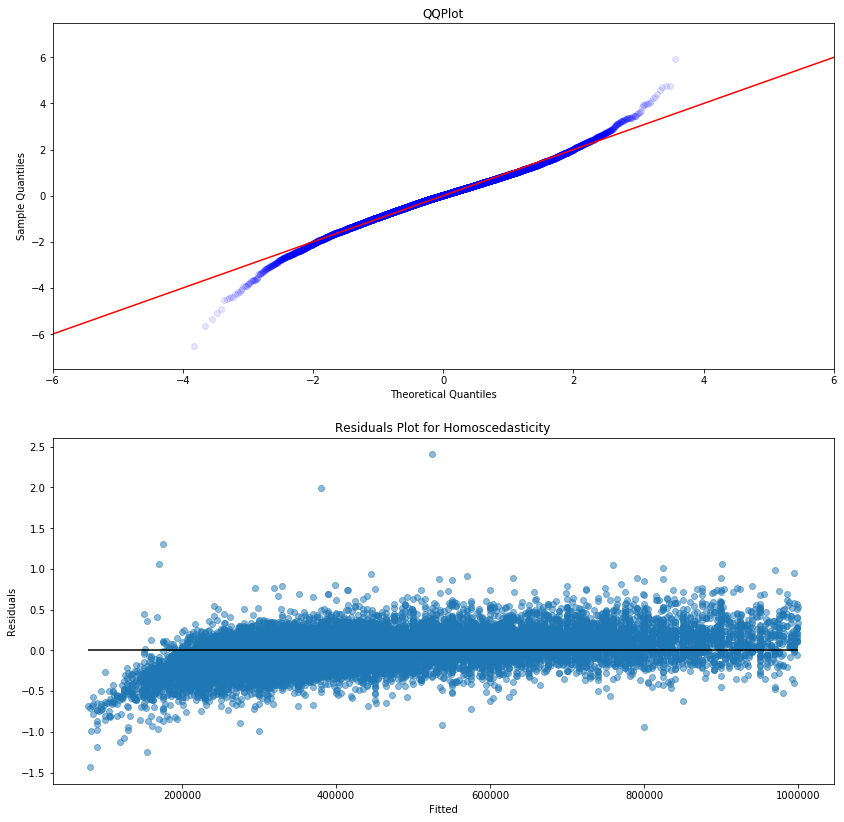

In [137]:
metrics(data_train, results, x_cols)

## model
A small function to create a model using statsmodels' OLS function

In [16]:
def model(data_m, x_cols):
    
    predictors = '+'.join(x_cols)
    f = outcome + '~' + predictors
    results = ols(formula=f, data=data_m).fit()
    return results

### unlog


In [17]:
def unlog(y):
    y = y.map(lambda x: np.e**x)
    return y

# Main

## Load and Split:

In [42]:
data = pd.read_csv('data/clean.csv')
df = pd.read_csv('data/distances.csv')
data = pd.concat([data, df],axis=1)


data = data[data.price < 1000000]
data.sort_index(axis=1, inplace=True)
data_train, data_test = tts(data, train_size=0.8, random_state=111)
data_train = data_train.reset_index().drop('index', axis=1)
data_test = data_test.reset_index().drop('index', axis=1)



##  Modelling

Initial model using only cleaned data:

Number of features: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     1604.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        19:34:30   Log-Likelihood:            -2.0305e+05
No. Observations:               15824   AIC:                         4.062e+05
Df Residuals:                   15787   BIC:                         4.065e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1.182e+08   4.87e+06    -24.292      0.000   -1.28e+08   -1.09e+08
Abandoned        -4131.0726    354.950    -11.638      0.000   -4826.815   -3435.331
Access_Point     -6363.7088    281.261    -22.626      0.000   -6915.013   -5812.404
Airport           -167.4957    307.199     -0.545      0.586    -769.641     434.650
Campground        3761.7398    249.134     15.099      0.000    3273.409    4250.071
Cemetery          -487.7177    513.632     -0.950      0.342   -1494.494     519.059
Commercial_Farm  -2887.6648    430.895     -6.702      0.000   -3732.269   -2043.061
Cultural          5824.9896    612.173      9.515      0.000    4625.061    7024.918
Educational       1.722e+04   1075.534     16.015      0.000    1.51e+04    1.93e+04
Fire              1879.2814    666.500      2.820      0.005     572.866    3185.697
Gate_wo_Building -1.088e+04    542.686    -20.048      0.000   -1.19e+04   -9816.289
Gated_w_Building  9499.8348    254.467     37.332      0.000    9001.050    9998.619
Government       -1.029e+04   1056.108     -9.745      0.000   -1.24e+04   -8221.418
Lodging           4664.6963    635.221      7.343      0.000    3419.591    5909.801
Police            4011.2048    266.250     15.066      0.000    3489.325    4533.084
Public_Gathering  2702.3145   1474.465      1.833      0.067    -187.806    5592.435
Seasonal_Home    -4568.1764    361.342    -12.642      0.000   -5276.447   -3859.905
Utility           1842.0637   1608.313      1.145      0.252   -1310.413    4994.540
bathroomsx4       3579.3032    447.042      8.007      0.000    2703.050    4455.556
bedrooms         -5964.7190   1082.574     -5.510      0.000   -8086.688   -3842.750
condition         2.725e+04   1243.899     21.909      0.000    2.48e+04    2.97e+04
date                87.7155      6.412     13.681      0.000      75.148     100.283
floorsx2         -1208.8242   1036.973     -1.166      0.244   -3241.410     823.761
grade             4.632e+04   1225.348     37.801      0.000    4.39e+04    4.87e+04
lat               2.387e+05   2.13e+04     11.199      0.000    1.97e+05     2.8e+05
long             -8.852e+05   4.07e+04    -21.726      0.000   -9.65e+05   -8.05e+05
sqft_above          42.5919     10.320      4.127      0.000      22.363      62.821
sqft_basement        5.8718     10.212      0.575      0.565     -14.145      25.889
sqft_living         55.1441     10.337      5.335      0.000      34.882      75.406
sqft_living15       48.1394      2.078     23.163      0.000      44.066      52.213
sqft_lot             0.3178      0.038      8.384      0.000       0.244       0.392
sqft_lot15          -0.2487      0.105     -2.380      0.017      -0.454      -0.044
view              2.408e+04   1304.170     18.466      0.000    2.15e+04    2.66e+04
waterfront        1.682

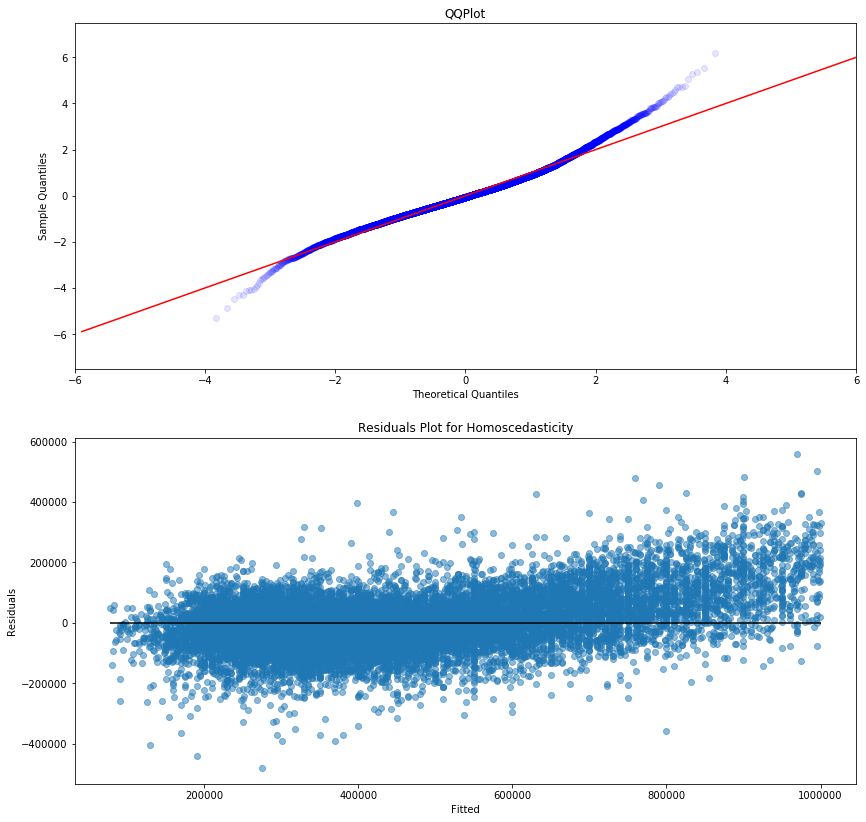

In [138]:
outcome = 'price'
x_cols = data_train.drop([outcome], axis=1).columns

results = model(data_train, x_cols)

metrics(data_train, results, x_cols)
results.summary()

In [139]:
y_hat_train = results.predict(data_train)
rmse_train = MSE(data_train.price, y_hat_train)**0.5
y_hat_test = results.predict(data_test)
rmse_test = MSE(data_test.price, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')

Train RMSE: 90503.58916320122 
 Test RMSE: 92445.73893425212


Number of features: 29


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     1991.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:02:04   Log-Likelihood:            -2.0306e+05
No. Observations:               15824   AIC:                         4.062e+05
Df Residuals:                   15794   BIC:                         4.064e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1.192e+08   3.27e+06    -36.442      0.000   -1.26e+08   -1.13e+08
Abandoned        -4205.6967    326.236    -12.892      0.000   -4845.157   -3566.236
Access_Point     -6400.4273    267.745    -23.905      0.000   -6925.237   -5875.617
Campground        3791.9113    214.273     17.697      0.000    3371.912    4211.911
Commercial_Farm  -2884.2634    426.114     -6.769      0.000   -3719.496   -2049.031
Cultural          5876.0593    602.683      9.750      0.000    4694.732    7057.387
Educational       1.754e+04   1016.699     17.257      0.000    1.56e+04    1.95e+04
Fire              2128.1176    645.532      3.297      0.001     862.802    3393.433
Gate_wo_Building -1.092e+04    517.163    -21.121      0.000   -1.19e+04   -9909.418
Gated_w_Building  9326.3998    196.537     47.454      0.000    8941.166    9711.634
Government       -9663.2701   1005.400     -9.611      0.000   -1.16e+04   -7692.570
Lodging           4673.7518    585.631      7.981      0.000    3525.849    5821.655
Police            3938.3773    240.281     16.391      0.000    3467.398    4409.356
Seasonal_Home    -4626.2854    292.964    -15.791      0.000   -5200.528   -4052.043
bathroomsx4       3442.1117    434.061      7.930      0.000    2591.304    4292.920
bedrooms         -5952.6091   1081.097     -5.506      0.000   -8071.682   -3833.536
condition         2.737e+04   1237.457     22.120      0.000    2.49e+04    2.98e+04
date                87.6013      6.411     13.664      0.000      75.035     100.167
grade             4.624e+04   1223.329     37.800      0.000    4.38e+04    4.86e+04
lat               2.328e+05   2.04e+04     11.429      0.000    1.93e+05    2.73e+05
long             -8.982e+05   3.28e+04    -27.369      0.000   -9.62e+05   -8.34e+05
sqft_above          35.3458      2.226     15.881      0.000      30.983      39.709
sqft_living         61.8571      2.451     25.234      0.000      57.052      66.662
sqft_living15       48.3362      2.058     23.483      0.000      44.302      52.371
sqft_lot             0.3188      0.038      8.414      0.000       0.245       0.393
sqft_lot15          -0.1987      0.102     -1.942      0.052      -0.399       0.002
view              2.409e+04   1297.063     18.573      0.000    2.15e+04    2.66e+04
waterfront        1.685e+05    1.5e+04     11.229      0.000    1.39e+05    1.98e+05
yr_built         -1551.7235     72.482    -21.408      0.000   -1693.796   -1409.651
yr_renovated       758.4209     73.184     10.363      0.000     614.972     901.870
==============================================================================
Omnibus:                     1070.159   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2195.329
Skew:                           0.464   P

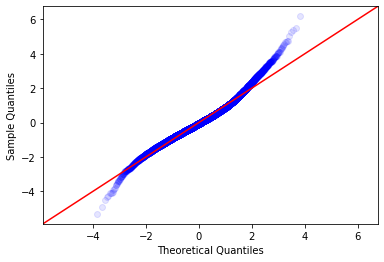

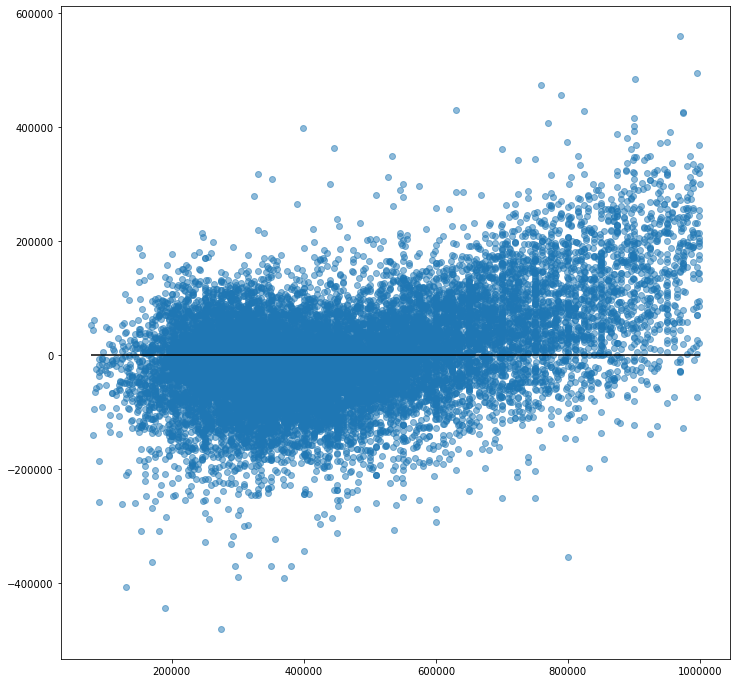

In [22]:
#simple feature selection
alpha=0.05
outcome = 'price'

data_t = data_train.copy()
x_cols = data_t.drop([outcome], axis=1).columns

x_cols = simple_selector(data_t, x_cols, alpha=alpha)

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

Number of features: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     2127.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:35:03   Log-Likelihood:            -2.0407e+05
No. Observations:               15824   AIC:                         4.082e+05
Df Residuals:                   15800   BIC:                         4.084e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -2.05e+07   1.29e+06    -15.839      0.000    -2.3e+07    -1.8e+07
date                82.7368      6.829     12.116      0.000      69.351      96.122
Access_Point     -7170.4618    270.379    -26.520      0.000   -7700.435   -6640.489
sqft_lot15           0.0464      0.108      0.428      0.668      -0.166       0.259
bedrooms         -6351.2985   1129.178     -5.625      0.000   -8564.616   -4137.981
Police            2891.8186    233.295     12.396      0.000    2434.534    3349.103
Educational      -3172.9688    751.159     -4.224      0.000   -4645.326   -1700.612
sqft_lot             0.2360      0.040      5.855      0.000       0.157       0.315
yr_built          -768.2531     37.061    -20.729      0.000    -840.897    -695.609
Lodging           8638.9962    607.969     14.210      0.000    7447.308    9830.684
Government       -5103.8641   1063.992     -4.797      0.000   -7189.410   -3018.318
Fire              -161.0795    677.678     -0.238      0.812   -1489.405    1167.246
grade             6.442e+04   1217.761     52.904      0.000     6.2e+04    6.68e+04
Abandoned        -3969.6935    341.364    -11.629      0.000   -4638.807   -3300.580
Cultural          1.007e+04    629.808     15.993      0.000    8837.951    1.13e+04
waterfront        1.842e+05    1.6e+04     11.536      0.000    1.53e+05    2.15e+05
long              9.518e+04   9391.553     10.135      0.000    7.68e+04    1.14e+05
lat               6.992e+05   7297.081     95.822      0.000    6.85e+05    7.14e+05
Commercial_Farm  -4446.9171    452.198     -9.834      0.000   -5333.277   -3560.557
Campground        2078.6132    220.447      9.429      0.000    1646.512    2510.714
sqft_living        109.4069      1.792     61.038      0.000     105.894     112.920
view              2.443e+04   1358.362     17.985      0.000    2.18e+04    2.71e+04
Gated_w_Building  1.032e+04    204.252     50.512      0.000    9916.726    1.07e+04
condition         2.358e+04   1285.127     18.345      0.000    2.11e+04    2.61e+04
==============================================================================
Omnibus:                     1047.866   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1980.260
Skew:                           0.480   Prob(JB):                         0.00
Kurtosis:                       4.443   Cond. No.                     4.71e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.71e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

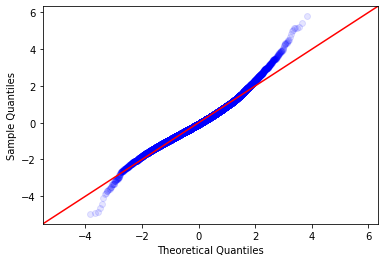

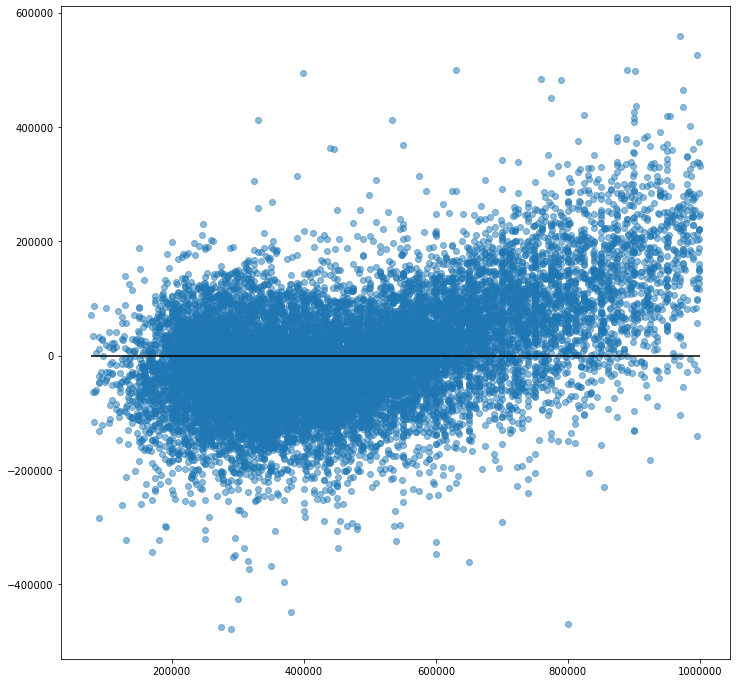

In [28]:
#simple feature selection with multicollinearity removal
multicollinearity_threshold=0.7
alpha=0.05
outcome = 'price'

data_t = data_train.copy()
x_cols = data_t.drop([outcome], axis=1).columns

x_cols = simple_selector(data_t, x_cols, alpha=alpha)
x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

In [29]:
y_hat_train = results.predict(data_t)
rmse_train = MSE(data_t.price, y_hat_train)**0.5
y_hat_test = results.predict(data_test)
rmse_test = MSE(data_test.price, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')

Train RMSE: 96521.9675288158 
 Test RMSE: 97506.5895559647


Number of features: 28


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1686.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:05:04   Log-Likelihood:            -2.0428e+05
No. Observations:               15824   AIC:                         4.086e+05
Df Residuals:                   15795   BIC:                         4.088e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -7.167e+06   2.07e+06     -3.460      0.001   -1.12e+07   -3.11e+06
condition         2.513e+04   1325.414     18.958      0.000    2.25e+04    2.77e+04
Lodging           6593.3667    656.691     10.040      0.000    5306.177    7880.557
Access_Point     -6464.7172    288.697    -22.393      0.000   -7030.596   -5898.839
yr_built         -1261.7360     42.685    -29.560      0.000   -1345.403   -1178.069
zipcode           -131.8522     19.958     -6.606      0.000    -170.973     -92.731
date                85.7698      6.923     12.389      0.000      72.200      99.340
Educational      -1583.4235    795.970     -1.989      0.047   -3143.616     -23.231
sqft_lot             0.3611      0.035     10.212      0.000       0.292       0.430
floorsx2           1.03e+04   1079.293      9.544      0.000    8185.304    1.24e+04
grade             6.812e+04   1229.631     55.402      0.000    6.57e+04    7.05e+04
long              6.489e+04   1.01e+04      6.395      0.000     4.5e+04    8.48e+04
Gated_w_Building  8454.0197    241.492     35.007      0.000    7980.667    8927.372
sqft_basement       13.3155      2.470      5.391      0.000       8.474      18.157
Cultural          6895.7193    644.013     10.707      0.000    5633.380    8158.058
lat               6.301e+05   9000.393     70.008      0.000    6.12e+05    6.48e+05
waterfront        1.932e+05   1.62e+04     11.910      0.000    1.61e+05    2.25e+05
Public_Gathering  5339.8054   1530.975      3.488      0.000    2338.919    8340.692
bedrooms          9733.6332   1088.292      8.944      0.000    7600.456    1.19e+04
Airport           2678.0814    302.692      8.848      0.000    2084.770    3271.392
bathroomsx4       9436.4842    458.346     20.588      0.000    8538.074    1.03e+04
Abandoned        -4508.7842    364.638    -12.365      0.000   -5223.516   -3794.053
Government       -7922.6148   1119.206     -7.079      0.000   -1.01e+04   -5728.843
Police            2191.9310    254.540      8.611      0.000    1693.004    2690.858
sqft_living15       88.6635      2.006     44.204      0.000      84.732      92.595
Commercial_Farm  -3821.9780    459.519     -8.317      0.000   -4722.688   -2921.268
Campground        3168.6897    261.670     12.109      0.000    2655.786    3681.594
view              2.341e+04   1408.227     16.626      0.000    2.07e+04    2.62e+04
Fire             -1428.4286    693.205     -2.061      0.039   -2787.189     -69.669
==============================================================================
Omnibus:                     1052.101   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1830.450
Skew:                           0.507   Prob(JB):                         0.00
Kurtosis:                       4.322   Cond. N

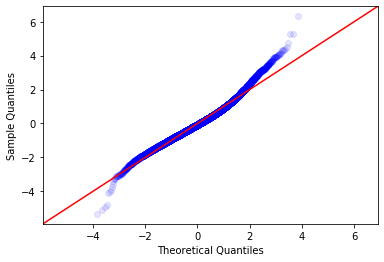

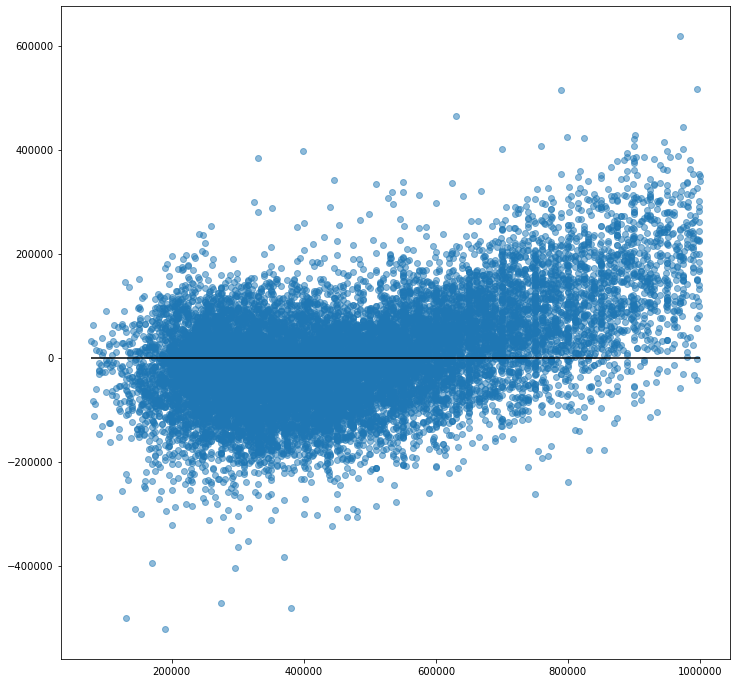

In [27]:
multicollinearity_threshold=0.7
alpha=0.05
outcome = 'price'

data_t = data_train.copy()
x_cols = data_t.drop([outcome], axis=1).columns


x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
x_cols = simple_selector(data_t, x_cols)

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

## What to Transform?
### One-Hot-Encoding

Candidates for OHE:
 - bedrooms
 - bathroomsx4
 - floorsx2
 - view
 - condition
 - grade
 - lat_long

In [ ]:
data.columns

In [ ]:
#Base model to compare against
multicollinearity_threshold=0.7
alpha=0.1
outcome = 'price'

data_t = data_train.copy()
x_cols = data_t.drop([outcome], axis=1).columns
x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
x_cols = simple_selector(data_t, x_cols)

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

In [ ]:
#Run models to ohe each ohe candidate separately:
multicollinearity_threshold=0.7
alpha=0.1
cand_ohe = ['bedrooms', 'bathroomsx4', 'floorsx2', 'view', 'condition', 'grade',
           'lat_long']

for feat in cand_ohe:
    data_t = data_train.copy()
    if feat == 'lat_long':
        data_t = bin_latlong(data_t)
    to_ohe = [feat]
    data_t = ohe(data_t, to_ohe)
    x_cols = data_t.drop([outcome], axis=1).columns
    x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
    x_cols = simple_selector(data_t, x_cols)

    
    results = model(data_t, x_cols)
    if results.rsquared_adj > 0.749:
        metrics(data_t, results, x_cols)
        print(feat)
        print(results.summary())

The only OHE candidate that made any significant improvement was the binned lat_long feature

### Log 

In [ ]:
data_t = data_train.copy()
multicollinearity_threshold=0.7
alpha=0.1
cand_log = data_t.drop(['lat', 'long', 'waterfront', 'zipcode'], axis=1).columns

for feat in cand_log:
    data_t = data_train.copy()
    to_log = [feat]
    data_t = log(data_t, to_log)
    x_cols = data_t.drop([outcome], axis=1).columns
    x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
    x_cols = simple_selector(data_t, x_cols)

    
    results = model(data_t, x_cols)
    if results.rsquared_adj > 0.749:
        metrics(data_t, results, x_cols)
        print(feat)
        print(results.summary())

In [ ]:
data_t = data_train.copy()
multicollinearity_threshold=0.7
alpha=0.1

cand_log = data_t.drop(['lat', 'long', 'waterfront', 'zipcode'], axis=1).columns
cand_log

### Scaled-Log

In [ ]:
data_t = data_train.copy()
multicollinearity_threshold=0.7
alpha=0.1
cand_log = data_t.drop(['lat', 'long', 'waterfront', 'zipcode'], axis=1).columns

for feat in cand_log:
    data_t = data_train.copy()
    to_log = [feat]
    data_t = minmax_plus(data_t, to_log)
    data_t = log(data_t, to_log)
    x_cols = data_t.drop([outcome], axis=1).columns
    x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
    x_cols = simple_selector(data_t, x_cols)

    
    results = model(data_t, x_cols)
    
    if results.rsquared_adj > 0.749:
        metrics(data_t, results, x_cols)
        print(feat)
        print(results.summary())

Benefitting from being log transformed are:
 - Gate_wo_building
 - Police
 - Seasonal Home
 - price
 - sqft_lot   
 
Benefitting from being scaled and then log transformed are:
 - sqft_above
 - sqft_living

Number of features: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     1645.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:23:22   Log-Likelihood:                 3062.6
No. Observations:               15824   AIC:                            -6051.
Df Residuals:                   15787   BIC:                            -5767.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           46.7320      6.397      7.305      0.000      34.193      59.271
Abandoned           -0.0125      0.001    -15.637      0.000      -0.014      -0.011
Access_Point        -0.0106      0.001    -17.250      0.000      -0.012      -0.009
Airport              0.0050      0.001      7.192      0.000       0.004       0.006
Campground           0.0123      0.001     21.409      0.000       0.011       0.013
Cemetery            -0.0075      0.001     -6.737      0.000      -0.010      -0.005
Commercial_Farm     -0.0068      0.001     -7.169      0.000      -0.009      -0.005
Cultural             0.0160      0.001     11.993      0.000       0.013       0.019
Educational         -0.0234      0.002    -11.836      0.000      -0.027      -0.020
Fire                -0.0082      0.001     -5.734      0.000      -0.011      -0.005
Gate_wo_Building     0.1262      0.010     12.752      0.000       0.107       0.146
Gated_w_Building     0.0225      0.001     39.243      0.000       0.021       0.024
Government          -0.0160      0.002     -6.905      0.000      -0.021      -0.011
Lodging              0.0189      0.001     13.807      0.000       0.016       0.022
Police               0.0706      0.003     22.551      0.000       0.064       0.077
Public_Gathering     0.0095      0.003      2.953      0.003       0.003       0.016
Seasonal_Home       -0.0143      0.009     -1.564      0.118      -0.032       0.004
Utility              0.0038      0.004      1.068      0.286      -0.003       0.011
bathroomsx4          0.0110      0.001     11.096      0.000       0.009       0.013
bedrooms            -0.0077      0.002     -3.237      0.001      -0.012      -0.003
condition            0.0632      0.003     23.024      0.000       0.058       0.069
date                 0.0002   1.41e-05     14.209      0.000       0.000       0.000
floorsx2             0.0128      0.002      5.185      0.000       0.008       0.018
grade                0.0995      0.003     36.894      0.000       0.094       0.105
lat                  1.8186      0.022     82.135      0.000       1.775       1.862
long                 0.7559      0.048     15.752      0.000       0.662       0.850
sqft_above           0.0052      0.000     11.392      0.000       0.004       0.006
sqft_basement       -0.0584      0.006     -9.438      0.000      -0.070      -0.046
sqft_living          0.0060      0.001     10.771      0.000       0.005       0.007
sqft_living15     9.955e-05   4.57e-06     21.780      0.000    9.06e-05       0.000
sqft_lot             0.0310      0.004      7.675      0.000       0.023       0.039
sqft_lot15       -4.416e-07   2.69e-07     -1.640      0.101   -9.69e-07    8.62e-08
view                 0.0501      0.003     17.388      0.000       0.044       0.056
waterfront           0.

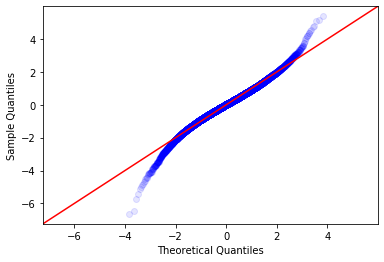

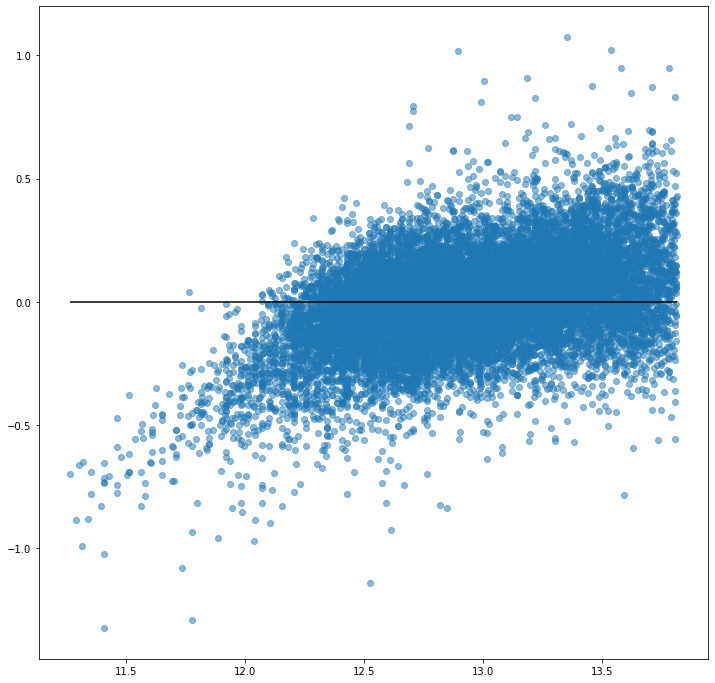

In [20]:
# Model so far:
multicollinearity_threshold=0.7
alpha=0.1
to_minmax = ['sqft_above', 'sqft_living']
to_log = ['Gate_wo_Building', 'Police', 'Seasonal_Home', 'price', 'sqft_lot']
to_ohe = ['lat_long']
          
data_t = data_train.copy()
data_t = bin_basement(data_t)
data_t = minmax_plus(data_t, to_minmax)
data_t = log(data_t, to_log)
data_t = bin_latlong(data_t)
data_t = ohe(data_t, to_ohe)

x_cols = data_t.drop([outcome], axis=1).columns
x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
x_cols = simple_selector(data_t, x_cols)

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

In [ ]:
# Model so far:
multicollinearity_threshold=0.7
alpha=0.1
to_minmax = ['sqft_above', 'sqft_living']
to_log = ['Gate_wo_Building', 'Police', 'Seasonal_Home', 'price', 'sqft_lot']
to_ohe = ['lat_long']
          
data_t = data_train.copy()
data_t = bin_basement(data_t)
data_t = minmax_plus(data_t, to_minmax)
data_t = log(data_t, to_log)
data_t = bin_latlong(data_t)
data_t = ohe(data_t, to_ohe)

# x_cols = data_t.drop([outcome], axis=1).columns
# x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
# x_cols = simple_selector(data_t, x_cols)

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

In [21]:
multicollinearity_threshold=0.7
alpha=0.1
test = True
to_minmax = ['sqft_above', 'sqft_living']
to_log = ['Gate_wo_Building', 'Police', 'Seasonal_Home', 'price', 'sqft_lot']
to_ohe = ['lat_long']
          
data_tt = data_test.copy()
data_tt = bin_basement(data_tt)
data_tt = minmax_plus(data_tt, to_minmax, test)
data_tt = log(data_tt, to_log)
data_tt = bin_latlong(data_tt, test)
data_tt = ohe(data_tt, to_ohe)


In [23]:
y_hat_train = results.predict(data_t)
rmse_train = MSE(unlog(data_t.price), unlog(y_hat_train))**0.5
y_hat_test = results.predict(data_tt)
rmse_test = MSE(unlog(data_tt.price), unlog(y_hat_test))**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')

Train RMSE: 96103.71563372374 
 Test RMSE: 106099.21033988372


In [ ]:
multicollinearity_threshold=0.7
alpha=0.1
data_t = data_train.copy()

to_minmax = ['sqft_above', 'sqft_living']
to_log = ['Gate_wo_Building', 'Police', 'Seasonal_Home', 'price', 'sqft_lot']
to_ohe = ['lat_long']
to_poly = data_t.drop(['lat', 'long', 'lat_long', 'waterfront', 'zipcode', 
                       'price'], axis=1).columns

print(data_t.price[0])
# data_t = minmax_plus(data_t, to_minmax)
data_t = bin_basement(data_t)
data_t = minmax_plus(data_t, to_poly)
print(data_t.price[0])
data_t = log(data_t, to_log)
print(data_t.price[0])
data_t = polynom(data_t, to_poly)
print(data_t.price[0])
data_t = bin_latlong(data_t)
print(data_t.price[0])
data_t = ohe(data_t, to_ohe)
print(data_t.price[0])
x_cols = data_t.drop([outcome], axis=1).columns


x_cols = simple_selector(data_t, x_cols, alpha=0.15)
x_cols = multicoll_remove(data_t, x_cols, 0.85)
x_cols = simple_selector(data_t, x_cols, alpha=0.1)
x_cols = multicoll_remove(data_t, x_cols, 0.8)
x_cols = stepwise_selector(data_t, x_cols, alpha=0.05)
x_cols = multicoll_remove(data_t, x_cols, 0.7)


print(data_t.price[0])
data_t = data_t[['price'] + x_cols]
print(data_t.price[0])
data_t = norm(data_t, x_cols)
print(data_t.price[0])
x_cols = rfe_selector(data_t, x_cols)


data_t = data_t[['price'] + x_cols]
data_t = data_t.sort_index(axis=1)

print(data_t.price[0])

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

In [ ]:
multicollinearity_threshold=0.7
alpha=0.1
data_tt = data_test.copy()
test = True

to_minmax = ['sqft_above', 'sqft_living']
to_log = ['Gate_wo_Building', 'Police', 'Seasonal_Home', 'price', 'sqft_lot']
to_ohe = ['lat_long']
to_poly = data_tt.drop(['lat', 'long', 'waterfront', 'zipcode', 'price'], axis=1).columns

print(data_tt.price[0])
data_tt = bin_basement(data_tt)
data_tt = minmax_plus(data_tt, to_minmax, test)
print(data_tt.price[0])
data_tt = log(data_tt, to_log)
print(data_tt.price[0])
data_tt = polynom(data_tt, to_poly)
print(data_tt.price[0])
data_tt = bin_latlong(data_tt, test)
print(data_tt.price[0])
data_tt = ohe(data_tt, to_ohe)
print(data_tt.price[0])


#test set may be missing dummies which the model looks for:
missing = list(set(x_cols) -set(list(data_tt.columns)))
for m in missing:
    data_tt[m] = 0
print(data_tt.price[0])
data_tt = data_tt[['price'] + x_cols]
data_tt = data_tt.sort_index(axis=1)
print(data_tt.price[0])
data_tt = norm(data_tt, x_cols, test)
print(data_tt.price[0])

# results 
# metrics(data_tt, results, x_cols)
# results.summary()

In [ ]:
y_hat_train = results.predict(data_t)
rmse_train = MSE(unlog(data_t.price), unlog(y_hat_train))**0.5
y_hat_test = results.predict(data_tt)
rmse_test = MSE(unlog(data_tt.price), unlog(y_hat_test))**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')

In [ ]:
data_train.columns

410000.0
410000.0
12.92391243868049
12.92391243868049
81


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


80
79
78
77
76
75
74
73
72
71
70
69
12.92391243868049
12.92391243868049
12.92391243868049
[(1, 0.2569593447972993), (2, 0.36838095589019426), (3, 0.5444739413210771), (4, 0.5447101576390272), (5, 0.5878954833579583), (6, 0.6278038767486371), (7, 0.667976436129383), (8, 0.6937160662696755), (9, 0.7015804148614089), (10, 0.7179741187659758), (11, 0.7293423744908962), (12, 0.740947266935674), (13, 0.7444046144017487), (14, 0.747235813866205), (15, 0.749595910067351), (16, 0.7547647452498605), (17, 0.7557492317741796), (18, 0.7572268194860454), (19, 0.7578243045966551), (20, 0.7600540968130227), (21, 0.7613531700434696), (22, 0.7618075881513494), (23, 0.7627143058672123), (24, 0.7632020399000459), (25, 0.7637783753877779), (26, 0.7652099575415161), (27, 0.765364005901525), (28, 0.7656209089136893), (29, 0.7663371694641887), (30, 0.7666022906970617), (31, 0.7668995763700553), (32, 0.7670969330505076), (33, 0.76732043271017), (34, 0.7675127175423846), (35, 0.7676832468510095), (36, 0.7676992

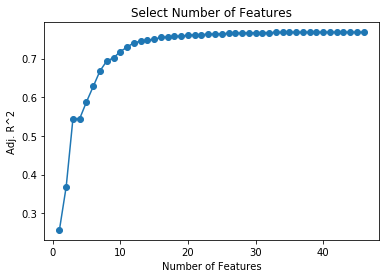

Select number of features
13
12.92391243868049
Number of features: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     3546.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        19:36:57   Log-Likelihood:                 1533.8
No. Observations:               15824   AIC:                            -3040.
Df Residuals:                   15810   BIC:                            -2932.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        12.9606      0.002   7420.348      0.000      12.957      12.964
Airport__Campground              -0.1296      0.005    -25.871      0.000      -0.139      -0.120
Access_Point__view                0.0507      0.002     27.588      0.000       0.047       0.054
condition__sqft_living15          0.0777      0.002     34.577      0.000       0.073       0.082
Campground__Gate_wo_Building      0.4107      0.005     87.061      0.000       0.401       0.420
Abandoned__Police                -0.0596      0.002    -27.902      0.000      -0.064      -0.055
Airport__Cemetery                -0.1000      0.004    -28.086      0.000      -0.107      -0.093
Gated_w_Building__Police          0.0569      0.002     25.938      0.000       0.053       0.061
grade                             0.0948      0.002     38.447      0.000       0.090       0.100
Airport__Seasonal_Home            0.1832      0.004     46.369      0.000       0.175       0.191
Cemetery__Gate_wo_Building        0.0417      0.003     14.658      0.000       0.036       0.047
Gate_wo_Building__sqft_living     0.1373      0.003     53.578      0.000       0.132       0.142
Access_Point__Campground         -0.1018      0.003    -39.945      0.000      -0.107      -0.097
Gate_wo_Building_pow_2           -0.3322      0.003   -102.410      0.000      -0.339      -0.326
==============================================================================
Omnibus:                     1033.288   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5002.208
Skew:                           0.041   Prob(JB):                         0.00
Kurtosis:                       5.753   Cond. No.                         7.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

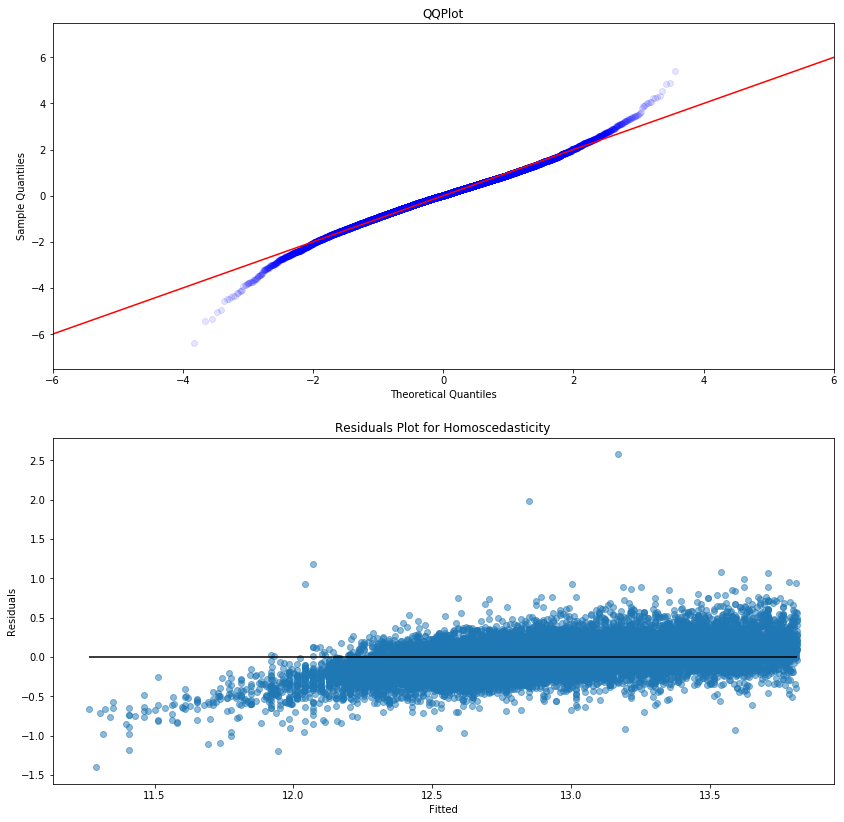

In [140]:
#model with no position:
multicollinearity_threshold=0.7
alpha=0.1
data_t = data_train.copy()

data_t = data_t.drop(['lat', 'long', 'zipcode'], axis=1)

to_minmax = ['sqft_above', 'sqft_living']
to_log = ['Gate_wo_Building', 'Police', 'Seasonal_Home', 'price', 'sqft_lot']
to_poly = data_t.drop(['waterfront', 
                       'price'], axis=1).columns

print(data_t.price[0])
data_t = bin_basement(data_t)
data_t = minmax_plus(data_t, to_poly)
print(data_t.price[0])
data_t = log(data_t, to_log)
print(data_t.price[0])
data_t = polynom(data_t, to_poly)
print(data_t.price[0])
x_cols = data_t.drop([outcome], axis=1).columns


x_cols = simple_selector(data_t, x_cols, alpha=0.15)
x_cols = multicoll_remove(data_t, x_cols, 0.85)
x_cols = simple_selector(data_t, x_cols, alpha=0.1)
x_cols = multicoll_remove(data_t, x_cols, 0.8)
x_cols = stepwise_selector(data_t, x_cols, alpha=0.05)
x_cols = multicoll_remove(data_t, x_cols, 0.7)


print(data_t.price[0])
data_t = data_t[['price'] + x_cols]
print(data_t.price[0])
data_t = norm(data_t, x_cols)
print(data_t.price[0])
x_cols = rfe_selector(data_t, x_cols)


data_t = data_t[['price'] + x_cols]
data_t = data_t.sort_index(axis=1)

print(data_t.price[0])

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

In [134]:
multicollinearity_threshold=0.7
alpha=0.1
data_tt = data_test.copy()
test = True

data_tt = data_tt.drop(['lat', 'long', 'zipcode'], axis=1)

to_minmax = ['sqft_above', 'sqft_living']
to_log = ['Gate_wo_Building', 'Police', 'Seasonal_Home', 'price', 'sqft_lot']
to_poly = data_tt.drop(['waterfront', 
                       'price'], axis=1).columns

print(data_tt.price[0])
data_tt = bin_basement(data_tt)
data_tt = minmax_plus(data_tt, to_poly)
print(data_tt.price[0])
data_tt = log(data_tt, to_log)
print(data_tt.price[0])
data_tt = polynom(data_tt, to_poly)
print(data_tt.price[0])


#test set may be missing dummies which the model looks for:
missing = list(set(x_cols) -set(list(data_tt.columns)))
for m in missing:
    data_tt[m] = 0
print(data_tt.price[0])
data_tt = data_tt[['price'] + x_cols]
data_tt = data_tt.sort_index(axis=1)
print(data_tt.price[0])
data_tt = norm(data_tt, x_cols, test)
print(data_tt.price[0])


462608.0
462608.0
13.044635322188094
13.044635322188094
13.044635322188094
13.044635322188094
13.044635322188094


In [143]:
y_hat_train = results.predict(data_t)
rmse_train = MSE(unlog(data_t.price), unlog(y_hat_train))**0.5
y_hat_test = results.predict(data_tt)
rmse_test = MSE(unlog(data_tt.price), unlog(y_hat_test))**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')

Train RMSE: 96451.00495345717 
 Test RMSE: 98453.08072502863


Number of features: 33


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     1484.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:09:19   Log-Likelihood:            -2.0406e+05
No. Observations:               15824   AIC:                         4.082e+05
Df Residuals:                   15790   BIC:                         4.085e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           1.5e+06    8.7e+04     17.249      0.000    1.33e+06    1.67e+06
Abandoned        -3123.8160    362.885     -8.608      0.000   -3835.113   -2412.519
Access_Point     -8270.6726    293.803    -28.150      0.000   -8846.560   -7694.786
Airport           6104.5867    291.222     20.962      0.000    5533.759    6675.414
Campground        9536.8435    219.876     43.374      0.000    9105.862    9967.825
Cemetery         -1.125e+04    457.757    -24.568      0.000   -1.21e+04   -1.03e+04
Commercial_Farm  -2731.1112    458.557     -5.956      0.000   -3629.936   -1832.287
Cultural          3651.8673    641.208      5.695      0.000    2395.026    4908.709
Educational       1.441e+04    823.362     17.498      0.000    1.28e+04     1.6e+04
Fire              -764.1172    690.396     -1.107      0.268   -2117.373     589.139
Gate_wo_Building -1.353e+04    230.469    -58.701      0.000    -1.4e+04   -1.31e+04
Gated_w_Building  8265.5907    260.452     31.736      0.000    7755.075    8776.106
Government       -8345.0366   1123.020     -7.431      0.000   -1.05e+04   -6143.788
Lodging           1444.5562    652.375      2.214      0.027     165.827    2723.285
Police            -679.7371    261.422     -2.600      0.009   -1192.155    -167.320
Public_Gathering -1448.2146   1548.265     -0.935      0.350   -4482.991    1586.562
Seasonal_Home     7205.3611    253.684     28.403      0.000    6708.112    7702.610
Utility           7190.5667   1702.991      4.222      0.000    3852.509    1.05e+04
bathroomsx4       3591.1951    476.065      7.543      0.000    2658.053    4524.337
bedrooms         -7230.8407   1152.501     -6.274      0.000   -9489.874   -4971.807
condition         2.723e+04   1320.645     20.617      0.000    2.46e+04    2.98e+04
date                85.4385      6.832     12.506      0.000      72.047      98.830
floorsx2         -1661.0592   1103.692     -1.505      0.132   -3824.423     502.304
grade             5.395e+04   1292.798     41.730      0.000    5.14e+04    5.65e+04
sqft_above          41.0374     10.996      3.732      0.000      19.485      62.590
sqft_basement        7.9219     10.882      0.728      0.467     -13.408      29.252
sqft_living         52.8435     11.015      4.798      0.000      31.253      74.434
sqft_living15       58.1926      2.199     26.458      0.000      53.882      62.504
sqft_lot             0.2132      0.040      5.290      0.000       0.134       0.292
sqft_lot15          -0.1651      0.111     -1.484      0.138      -0.383       0.053
view              2.492e+04   1384.186     18.001      0.000    2.22e+04    2.76e+04
waterfront        2.072e+05    1.6e+04     12.956      0.000    1.76e+05    2.39e+05
yr_built         -1642.6026     77.750    -21.127      0.000   -1795.002   -1490.203
yr_renovated       747.

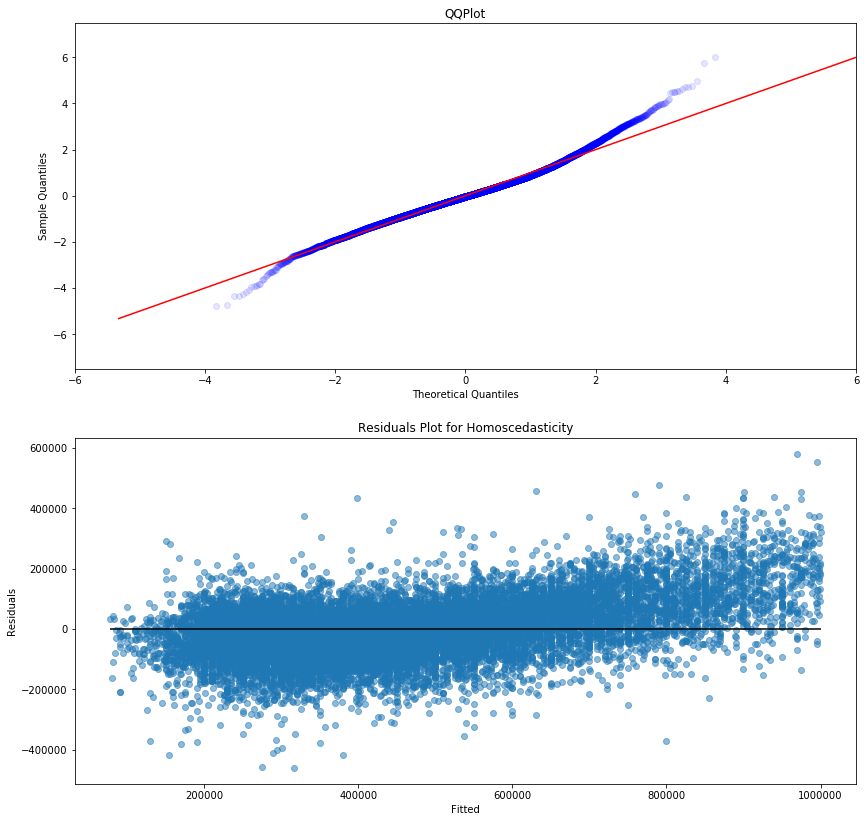

In [141]:
#Base model with no position
outcome = 'price'
x_cols = data_train.drop([outcome,'lat', 'long', 'zipcode'], axis=1).columns

results = model(data_train, x_cols)

metrics(data_train, results, x_cols)
results.summary()

In [144]:
y_hat_train = results.predict(data_train)
rmse_train = MSE(data_train.price, y_hat_train)**0.5
y_hat_test = results.predict(data_test)
rmse_test = MSE(data_test.price, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')

Train RMSE: 96451.00495345717 
 Test RMSE: 98453.08072502863


In [225]:
data_r = pd.concat([data_train, y_hat_train], axis=1)
data_r.rename(columns={0:'residuals'}, inplace=True)
data_r.residuals = data_r.price - data_r.residuals
data_r  = data_r[['lat', 'long', 'residuals']]
data_r.describe()

In [235]:
data_ra = data_r[data_r.residuals < -60092]
data_rb = data_r[data_r.residuals > 53685]
print(len(data_ra), len(data_rb))


3956 3956


In [251]:
minb = 53685
maxb = 581376
mina = -461548
maxa = -60092

data_rb.loc[:,'colour'] = data_rb.residuals.apply(lambda x: 
                        '#'+str(hex(int(255*(x-minb)/(maxb-minb))))[2:]+'0000')

data_ra.loc[:,'colour'] = data_ra.residuals.apply(lambda x: 
                        '#00ff'+str(hex(int(255*(x-mina)/(maxa-mina))))[2:])

In [252]:
lat = 47.5480
long = -121.9836
base_map = folium.Map([lat,long], zoom_start=9, width=900, height=900)

for df in [data_ra, data_rb]:
    x = df.lat
    y = df.long
    z = df.colour
    points = list(zip(x,y,z))
    for p in points:

        lat = p[0]
        long = p[1]
        marker = folium.CircleMarker(location=[lat,long], radius=2, color=p[2])
        marker.add_to(base_map)   


base_map

In [208]:
points[0][2]

'4f0000'

In [ ]:
X = data_train.drop(outcome, axis=1)
pca = PCA(n_components = 6, whiten=True)
pca.fit(X)

In [ ]:
pca.components_

In [ ]:
#Future work: residuals as percent of price

In [ ]:
data


In [ ]:
y_hat_train.describe()
MSE(data_t.price, y_hat_train)**0.5

In [ ]:
y_hat_test.describe()